# Projeto Aprendizagem de Máquina

O projeto requer a utilização dos seguintes classificadores:
1. Arvores de decisão;
2. Bayesiano ingenuo;
3. Regressão logistica;
4. K-vizinhos (Utilizar a distância Euclidiana e o conjunto de validação para fixar o número de vizinhos k).

De forma a classificar o tipo do vinho (branco ou vermelho) dado pelo seguinte [dataset wine quality](https://archive.ics.uci.edu/dataset/186/wine+quality). É necessário utilizar a mais diversas técnicas de forma a maximizar a precision (precisão), cobertura (recall) e f1-score de cada um dos classificadores.

## Importações de bibliotecas de uso geral

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

/tmp/ipykernel_13340/3959111921.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Importação do dataset

In [2]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [3]:
from ucimlrepo import fetch_ucirepo

wine_dot = fetch_ucirepo(id=186)
base_wine = wine_dot.data.original
base_wine.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


## Tratamento dos dados
Não há nenhum valor nulo na tabela, não sendo necessário preencher com algum valor padrão. Além deste, foi testado se existia alguma feature muito correlacionada com outra, e não foi o caso.

In [4]:
import random
random.seed(42)

base_wine.isnull().any().any()

False

In [ ]:
x = base_wine.drop("color", axis=1)
y = base_wine["color"]

### Normalização dos dados

Uma vez que o máximo de cada coluna de X varia entre 1 até 440, então nós podemos normalizar os dados através do StandardScaler que remove a média e dimensiona os dados para a variância unitária. Ou seja, para um valor X é calculado:

![fórmula](https://latex.codecogs.com/svg.image?&space;z=\frac{(x-u)}{s})

Onde **u** é a média das amostras de treinamento (_raw_treino_x_) e **s** é o desvio padrão das amostras de treinamento.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)

### Verificação de valores constantes

Caso os valores de alguma feature são constantes, eles podem ser removidos da amostragem. Para saber esse tipo de informação, basta verificar a amostragem de cada feature para as classes (color), e no caso do gráfico de violino os dados são constantes quando estiverem em forma de linha. Neste caso, nenhuma das features são constantes.

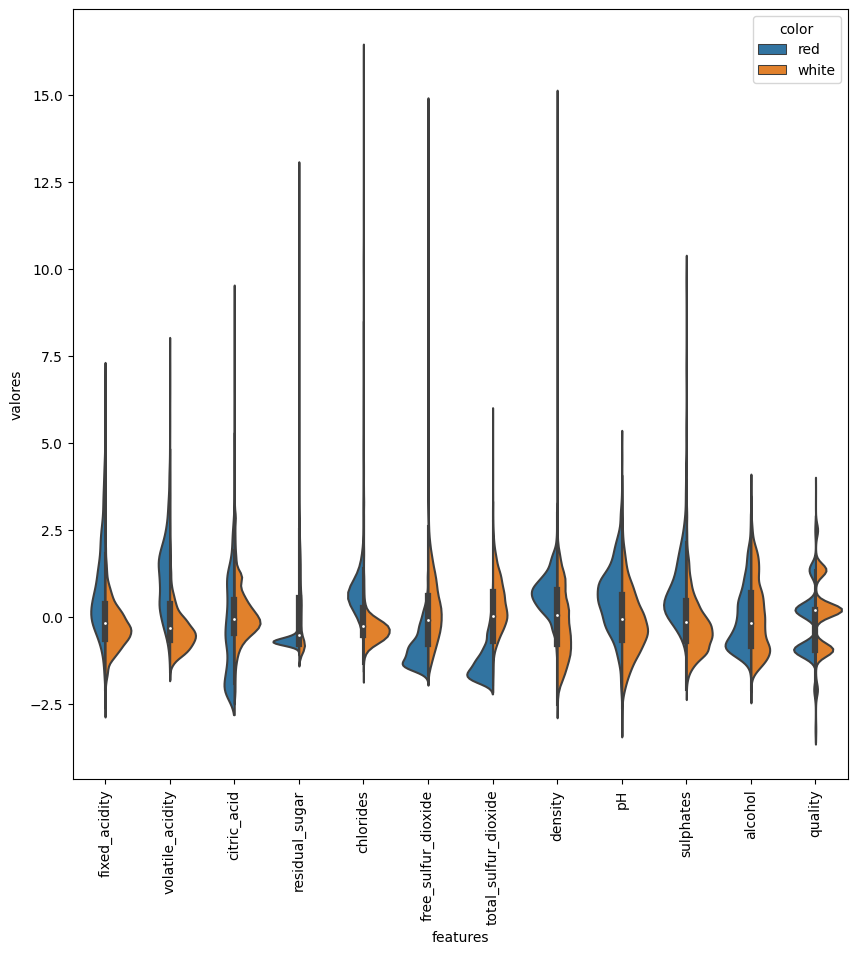

In [ ]:
import pandas, seaborn

def plot_violin_graph(x_values: pandas.DataFrame,
                      y_values: pandas.DataFrame,
                      y_name: str, x_name: str) -> None:
    data_plot = pandas.concat([y_values, x_values], axis=1)
    data_plot = pandas.melt(data_plot, id_vars=y_name, var_name=x_name,
                            value_name="valores")

    plt.figure(figsize=(10,10))

    seaborn.violinplot(x=x_name, y="valores", hue=y_name,
                       data=data_plot, split=True)

    plt.xticks(rotation = 90)

x_df = pandas.DataFrame(data=scaled_x, columns=x.columns)
plot_violin_graph(x_df, y, "color", "features")

### Análise de correlação de features

Se as features estão muito correlacionadas, então você pode remove-las. Para analisar esse tipo de coisa, é obtido a matriz de correlação e descartado as features com correlação acima de um determinado limiar. Neste caso, nenhuma das features estão muito correlacionadas, pois a maior correlação é de 70%.

<Axes: >

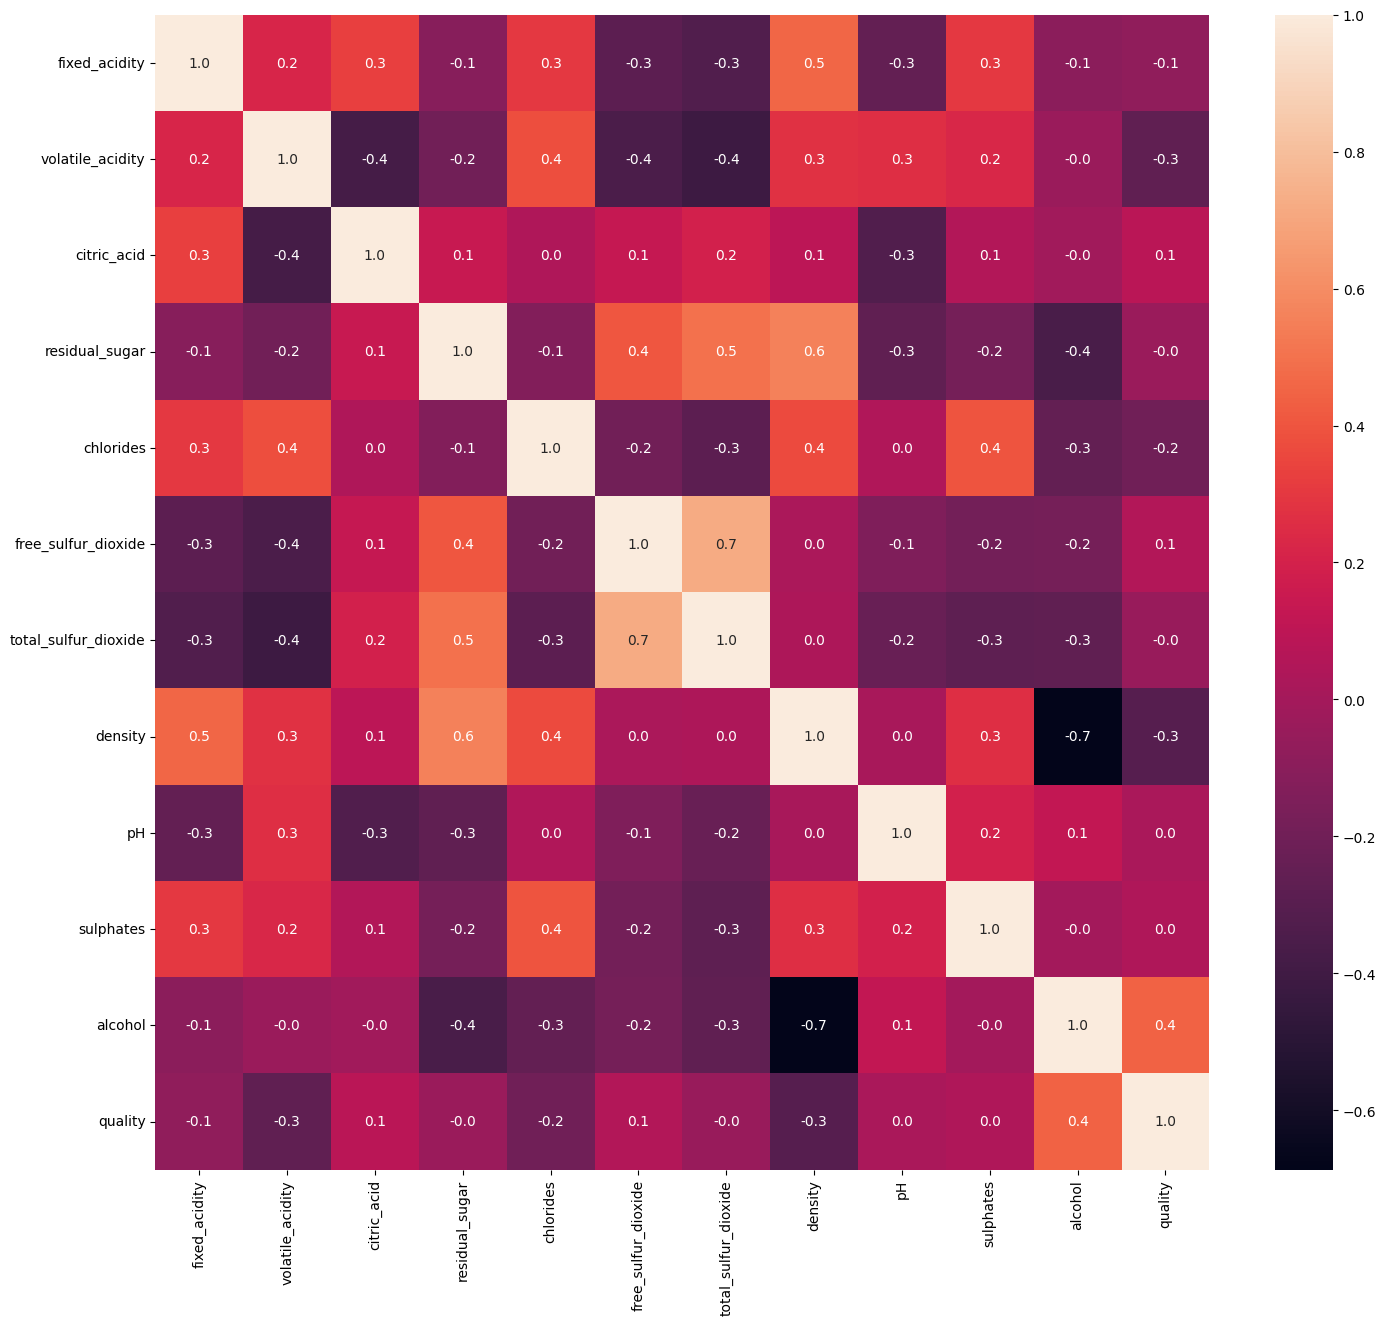

In [ ]:
corr_matrix = x_df.corr()
plt.figure(figsize=(17, 15))
seaborn.heatmap(corr_matrix, annot = True, fmt = ".1f")

In [ ]:
corr_matrix[corr_matrix[corr_matrix>0.99].sum() > 1]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality


### Divisão dos dados em treino/teste

Será setado o seed para deixar todos os testes de forma deterministica. Separar as variáveis das classes, e separar os dados de treinamento para com os dados de teste.

In [ ]:
from sklearn.model_selection import train_test_split

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                        stratify = y)

### Obtenção do score de referência

É utilizado o _DummyClassifier_ que é um classificador que não gera nenhum insight, pois utiliza regras simples. Dessa forma é possível saber se no fim da classificação a pontuação ficou pior ou melhor do que a base. No caso está sendo utilizado a estratégia de "mais frequente" que sempre vai atribuir a classe mais frequente nos dados de treinamento observado ("white").

In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(treino_x, treino_y)
dummy.score(teste_x, teste_y)

0.7538461538461538

## Decision Tree Classifier

Este algoritmo é chamado de árvore de decisão pois o modelo se divide em forma de árvore, iniciando com um nó inicial que se divide formando ramos (possíveis caminhos).

### Busca pelos hiperparâmetros

O GridSearchCV nos permite testar o modelo (neste caso o DecisionTreeClassifier) com os mais diversos parâmetros, devolvendo os melhores parâmetros, com base na validação cruzada de tamanho 5, que será explicada no fim do projeto. Os parâmetros testados são:

1. **max_depth**: A profundidade máxima da árvore, no qual caso for None irá se expandir até que todas as folhas sejam puras ou contenham menos do que min_samples_split.
2. **min_samples_split**: O número mínimo de amostras para dividir um nó.
3. **min_samples_leaf**: O número mínimo de amostras para ser uma folha.
4. **criterion**: A função para medir a qualidade e uma divisão, podendo ser a medida de impureza "Gini", que mede a frequência de um elemento escolhido aleatoriamente ser rotulado incorretamente, e a "Entropia" que mede a desordem de um grupo.

![Entropia](https://ichi.pro/assets/images/max/724/1*a8okAODlAOHgt01-G7vY4w.png)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

parameters = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [16, 32, 64, 128],
    "min_samples_leaf": [16, 32, 64, 128],
    "criterion": ["gini", "entropy"]
}

search = GridSearchCV(DecisionTreeClassifier(), parameters)
search.fit(x, y)
search.best_params_, search.best_score_

({'criterion': 'entropy',
  'max_depth': 5,
  'min_samples_leaf': 16,
  'min_samples_split': 32},
 0.9779873275300528)

### Treinamento e teste

É instanciado a árvore de decisão com profundidade 2, realizado o treinamento, predito os valores de teste e calculado a pontuação.

- **precision**: Foco nos verdadeiros positivos (ignora os T/F negativos)
- **recall**: Foco nos realmente positivos (considera os falso negativos)
- **f1-score**: Equilíbrio entre a acurácia e o recal
- **accuracy**: O quanto o modelo acertou (verdadeiro positivo/negativo)

In [ ]:
from sklearn.metrics import classification_report

tree_model = DecisionTreeClassifier(**search.best_params_)
tree_model.fit(treino_x, treino_y)

predicts = tree_model.predict(teste_x)
print(classification_report(teste_y, predicts))

              precision    recall  f1-score   support

         red       0.99      0.94      0.97       400
       white       0.98      1.00      0.99      1225

    accuracy                           0.98      1625
   macro avg       0.98      0.97      0.98      1625
weighted avg       0.98      0.98      0.98      1625



### Matriz de confusão

Para averiguarmos o resultado, podemos utilizar uma matriz de confusão que é composta pelos componentes TP, FP, FN, TN na seguinte disposição:
```
[VerdadeiroPositivo (TP)      FalsoNegativo (FN)
 FalsoPositivo (FP)           VerdadeiroNegativo (TN)]
```

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


0.9833846153846154

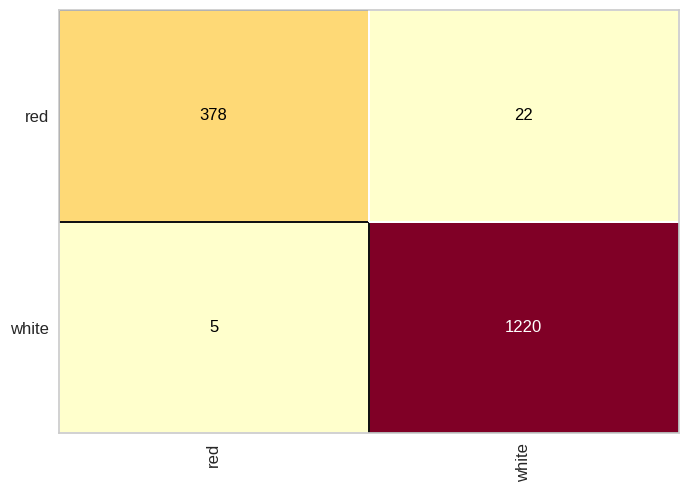

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(tree_model, classes=["red", "white"])
cm.fit(treino_x, treino_y)
cm.score(teste_x, teste_y)

### Plotagem da árvore

O gráfico mostra (1) a feature mais importante para a divisão, (2) o índice de impureza (Gini) que deve ser minimizado, (3) o número de amostras que chegaram no nó e (4) a distribuição de amostras, onde o primeiro valor é a quantidade de vinhos classificados como "red" e o segundo valor são os classificados como "white".

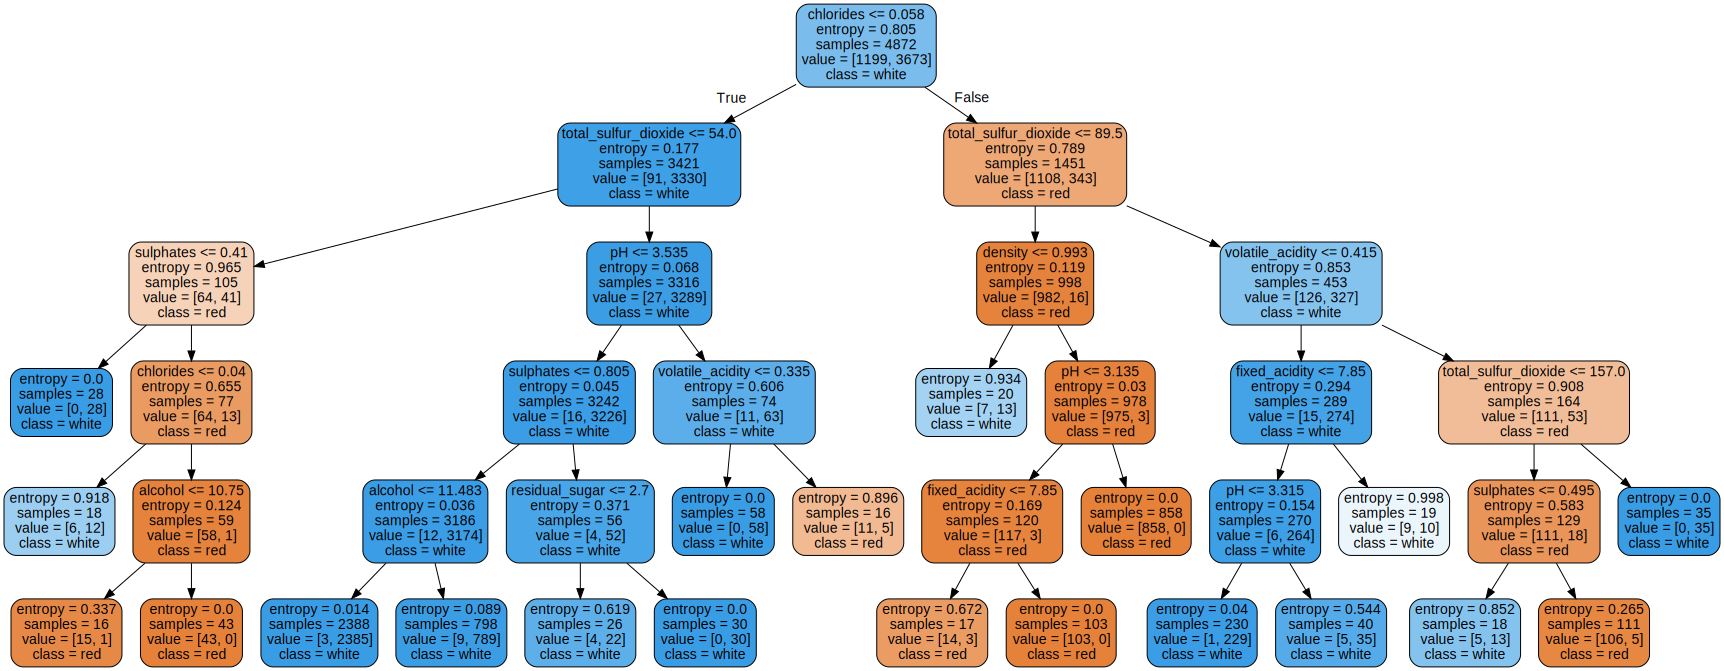

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_model, out_file=None, rounded=True,
                           filled=True, feature_names=x.columns,
                           class_names=["red", "white"])
graphviz.Source(dot_data)

## Gaussian Naive Bayes Model

O funcionamento deste classificador é baseado no Teorema de Bayes, utilizando as probabilidades a priori e a posteriori no cálculo da probabilidade de uma instância percenter a uma classe. É chamado de ingênuo pois supõe a independência condicional entre os atributos.

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()
gnb_model.fit(treino_x, treino_y)

gnb_predict = gnb_model.predict(teste_x)
print(classification_report(teste_y, gnb_predict))

              precision    recall  f1-score   support

         red       0.92      0.98      0.95       400
       white       0.99      0.97      0.98      1225

    accuracy                           0.97      1625
   macro avg       0.96      0.98      0.97      1625
weighted avg       0.98      0.97      0.98      1625



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


0.9747692307692307

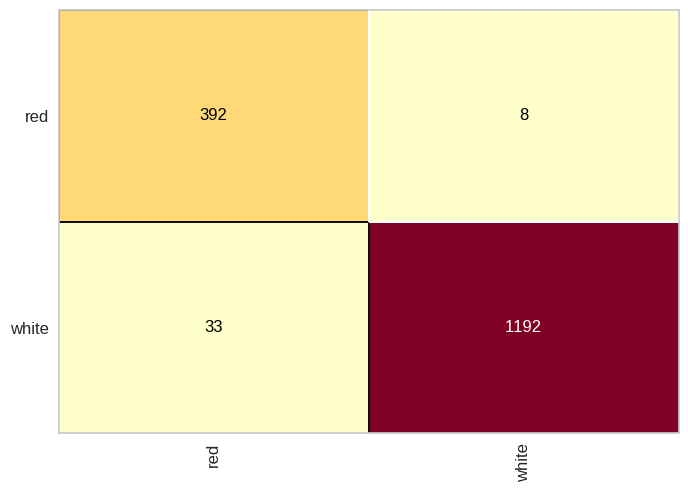

In [ ]:
cm = ConfusionMatrix(gnb_model, classes=["red", "white"])
cm.fit(treino_x, treino_y)
cm.score(teste_x, teste_y)

## Logistic Regression Model

Este é um modelo estatístico utilizado para relações binárias de variáveis independentes. Estima a probabilidade da ocorrência de um evento, limitada a 0 e 1.

### Balanceamento de classes

Uma vez que possuem 3x classes "white", então vale a pena tentar balancear o número de classes, onde são criados novos exemplos da classe minoritária através do _Synthetic Minority Over-sampling Technique_. Dessa forma, podemos aumentar o score para a classe "red". Se não fizer isso, o Logistic Regression não vai conseguir convergir, exibindo o erro "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT."

In [ ]:
from imblearn.over_sampling import SMOTE

smt = SMOTE()
X, Y = smt.fit_resample(x, y)

In [ ]:
scaler = StandardScaler()
normalized_x =scaler.fit_transform(X)

treino_X, teste_X, treino_Y, teste_Y = train_test_split(
    normalized_x, Y, test_size = 0.25, stratify = Y)

### Treinamento e validação do modelo

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(treino_X, treino_Y)

lr_predict = lr_model.predict(teste_X)
print(classification_report(teste_Y, lr_predict))

              precision    recall  f1-score   support

         red       1.00      0.99      0.99      1224
       white       0.99      1.00      0.99      1225

    accuracy                           0.99      2449
   macro avg       0.99      0.99      0.99      2449
weighted avg       0.99      0.99      0.99      2449



0.9942833809718252

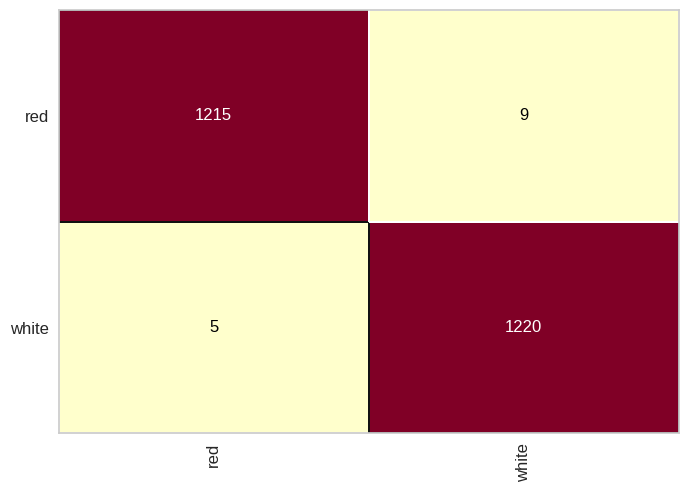

In [ ]:
cm = ConfusionMatrix(lr_model, classes=["red", "white"])
cm.fit(treino_X, treino_Y)
cm.score(teste_X, teste_Y)

## K Neighbors Classifier

A partir dos dados tratados, é realizado o treinamento com o modelo de k-vizinhos.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(metric='euclidean')
knn_model.fit(treino_x, treino_y)
knn_predicted = knn_model.predict(teste_x)

print(classification_report(teste_y, knn_predicted))

              precision    recall  f1-score   support

         red       0.92      0.85      0.88       400
       white       0.95      0.98      0.96      1225

    accuracy                           0.95      1625
   macro avg       0.94      0.91      0.92      1625
weighted avg       0.94      0.95      0.94      1625



### Visualização dos clusters

É utilizado o PCA para diminuir a dimensionalidade para 2D, então criado uma malha plotando cada resultado do KNN em comparação aos dados redimensionados, podendo ver como ficou a divisão dos clusters KNN.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
<ipython-input-32-ba914d3d26f0>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xx, yy, c=Z, cmap=plt.cm.Paired)
<ipython-input-32-ba914d3d26f0>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')


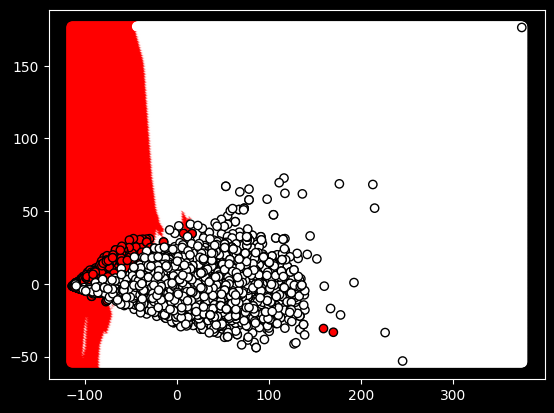

In [ ]:
from sklearn.decomposition import PCA

def see_knn_chart(knn: KNeighborsClassifier, reducer: PCA,
                  X: pandas.DataFrame, y: pandas.DataFrame):
    h = 1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    concatened = np.c_[xx.ravel(), yy.ravel()]
    to_predict = reducer.inverse_transform(concatened)
    Z = knn.predict(to_predict)

    plt.figure()
    plt.style.use('dark_background')
    plt.scatter(xx, yy, c=Z, cmap=plt.cm.Paired)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
    plt.axis('tight')
    plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)
see_knn_chart(knn_model, pca, X_pca, y)

## Validação cruzada

Uma forma de calcular a pontuação de um modelo é dividindo o dataset em treino, teste e validação, de forma a evitar overfitting, porém isso diminui o tamanho do dataset, então uma forma é realizar a validação cruzada, que vai dividir o dataset em K tamanhos e utilizar K - 1 no treinamento e um para teste.

![Cross validation](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_model, x, y, cv=5)
print("DecisionTree %0.2f de acurácia com desvio padrão de %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(gnb_model, x, y, cv=5)
print("Gaussian Naive Bayes %0.2f de acurácia com desvio padrão de %0.2f" % (scores.mean(), scores.std()))

# Foi utilizado o normalized_x com o dataset aumentado pelo SMOTE para evitar
# o erro de falta de convergência por falta de dados.
scores = cross_val_score(lr_model, normalized_x, Y, cv=5)
print("Logistic regression %0.2f de acurácia com desvio padrão de %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(knn_model, x, y, cv=5)
print("K Neighbors %0.2f de acurácia com desvio padrão de %0.2f" % (scores.mean(), scores.std()))

DecisionTree 0.98 de acurácia com desvio padrão de 0.01
Gaussian Naive Bayes 0.97 de acurácia com desvio padrão de 0.01
Logistic regression 0.99 de acurácia com desvio padrão de 0.00
K Neighbors 0.94 de acurácia com desvio padrão de 0.01
